In [48]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms
import torch.optim as optim

In [57]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done


In [58]:
# Import PGD attack
import cleverhans

from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [59]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip

--2025-02-22 07:36:42--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12467105 (12M) [application/x-zip-compressed]
Saving to: ‘LFW-dataset.zip.2’

LFW-dataset.zip.2   100%[===================>]  11.89M  17.8MB/s    in 0.7s    

2025-02-22 07:36:43 (17.8 MB/s) - ‘LFW-dataset.zip.2’ saved [12467105/12467105]



In [60]:
# Uncompress the dataset
!unzip -uq 'LFW-dataset.zip' -d 'sample_data/'

In [61]:
# Define a function for loading the dataset
class MyDataset(Dataset):
    def __init__(self, root_dir, transform, split):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, split)
        self.labels_file = np.genfromtxt(root_dir + split + "_labels.csv", delimiter=',', dtype=np.int32)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file[idx]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [62]:
# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224 x 224 pixels
    transforms.ToTensor(),  # Convert the images to a PyTorch tensor
])

In [63]:
# Download the train, test, and validation datasets
train_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='train')
test_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='test')
val_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='validation')

In [64]:
# Check the datasets
print('Train dataset length:', len(train_dataset))
print('Test dataset length:', len(test_dataset))
print('Validation dataset length:', len(val_dataset))


Train dataset length: 3043
Test dataset length: 1049
Validation dataset length: 1021


In [65]:
# Create dataloaders to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [66]:
# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open("sample_data/LFW-dataset/name_list.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

In [67]:
name_list

['Gloria_Macapagal_Arroyo',
 'Jennifer_Capriati',
 'Laura_Bush',
 'Winona_Ryder',
 'Tiger_Woods',
 'Hugo_Chavez',
 'John_Negroponte',
 'George_W_Bush',
 'Roh_Moo-hyun',
 'Paul_Bremer',
 'George_Robertson',
 'Tom_Daschle',
 'Ricardo_Lagos',
 'Jennifer_Lopez',
 'Jose_Maria_Aznar',
 'Silvio_Berlusconi',
 'Vicente_Fox',
 'Jennifer_Aniston',
 'Gerhard_Schroeder',
 'David_Beckham',
 'Kofi_Annan',
 'Igor_Ivanov',
 'Jiang_Zemin',
 'Mahmoud_Abbas',
 'Pete_Sampras',
 'Guillermo_Coria',
 'Donald_Rumsfeld',
 'Megawati_Sukarnoputri',
 'Jeremy_Greenstock',
 'Junichiro_Koizumi',
 'Jack_Straw',
 'Rudolph_Giuliani',
 'Jacques_Chirac',
 'Saddam_Hussein',
 'John_Ashcroft',
 'Lindsay_Davenport',
 'Naomi_Watts',
 'Lleyton_Hewitt',
 'Hamid_Karzai',
 'Tom_Ridge',
 'Recep_Tayyip_Erdogan',
 'Tony_Blair',
 'Hans_Blix',
 'Jean_Chretien',
 'Nestor_Kirchner',
 'Gray_Davis',
 'Michael_Bloomberg',
 'Luiz_Inacio_Lula_da_Silva',
 'Juan_Carlos_Ferrero',
 'Vladimir_Putin',
 'Serena_Williams',
 'Alejandro_Toledo',
 'Alva

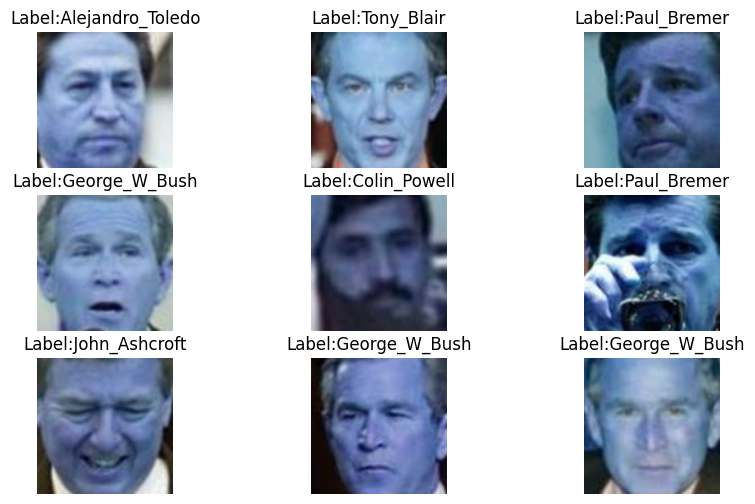

In [68]:
# Plot several images and labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str(name_list[labels[0]]))
    plt.axis('off')

In [69]:
from pathlib import Path
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import datetime
now = datetime.datetime.now

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torchvision
from torchvision import transforms
import copy

In [70]:
import os
from functools import partial
from itertools import product
from collections import OrderedDict
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision import datasets, transforms as T
from sklearn.model_selection import train_test_split, KFold
import natsort
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from os import listdir
import pandas
from pandas import DataFrame
import tensorflow as tf

In [71]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [72]:
!pip -q install vit_pytorch linformer

In [73]:
from vit_pytorch.efficient import ViT
from linformer import Linformer

In [74]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [75]:
efficient_transformer = Linformer(
    dim=128, # dimension of the attention heads
    seq_len=49+1,  # length of input sequences: 7x7 patches + 1 class token
    depth=12, # number of stacked encoder blocks in the model
    heads=8, # number of attention heads
    k=64  # reduce the input dimension for efficiency
)

In [125]:
model = ViT(
    dim=128, # dimension of the attention heads
    image_size=224, # resolution of images
    patch_size=32, # size of image patches
    num_classes=64, # number of classes
    transformer=efficient_transformer, # the transformer backbone
    channels=3, # number of channels in images
)

In [126]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [127]:
model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

In [128]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [129]:
epochs = 20

In [130]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    # Training loop
    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    # Store training loss and accuracy
    train_losses.append(epoch_loss.item())
    train_accuracies.append(epoch_accuracy.item())

    # Validation loop
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_dataloader)
            epoch_val_loss += val_loss / len(val_dataloader)

        # Store validation loss and accuracy
        val_losses.append(epoch_val_loss.item())
        val_accuracies.append(epoch_val_accuracy.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.7679 - acc: 0.1693 - val_loss : 3.6510 - val_acc: 0.1719



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.4988 - acc: 0.1975 - val_loss : 3.2348 - val_acc: 0.2638



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.8729 - acc: 0.3352 - val_loss : 2.6552 - val_acc: 0.3764



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.3054 - acc: 0.4688 - val_loss : 2.2588 - val_acc: 0.4734



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.8199 - acc: 0.6321 - val_loss : 1.8915 - val_acc: 0.5956



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.4186 - acc: 0.7446 - val_loss : 1.6191 - val_acc: 0.6640



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.1030 - acc: 0.8234 - val_loss : 1.3985 - val_acc: 0.7322



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.8448 - acc: 0.8957 - val_loss : 1.2005 - val_acc: 0.7753



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6185 - acc: 0.9333 - val_loss : 1.0600 - val_acc: 0.8123



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4563 - acc: 0.9662 - val_loss : 0.9678 - val_acc: 0.8251



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3368 - acc: 0.9799 - val_loss : 0.8831 - val_acc: 0.8290



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.2357 - acc: 0.9936 - val_loss : 0.8434 - val_acc: 0.8408



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.1736 - acc: 0.9984 - val_loss : 0.7989 - val_acc: 0.8319



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.1280 - acc: 0.9993 - val_loss : 0.7697 - val_acc: 0.8439



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0988 - acc: 0.9997 - val_loss : 0.7546 - val_acc: 0.8418



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0797 - acc: 1.0000 - val_loss : 0.7381 - val_acc: 0.8438



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0670 - acc: 1.0000 - val_loss : 0.7291 - val_acc: 0.8438



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0578 - acc: 1.0000 - val_loss : 0.7407 - val_acc: 0.8389



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0504 - acc: 1.0000 - val_loss : 0.7269 - val_acc: 0.8419



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0446 - acc: 1.0000 - val_loss : 0.7279 - val_acc: 0.8429



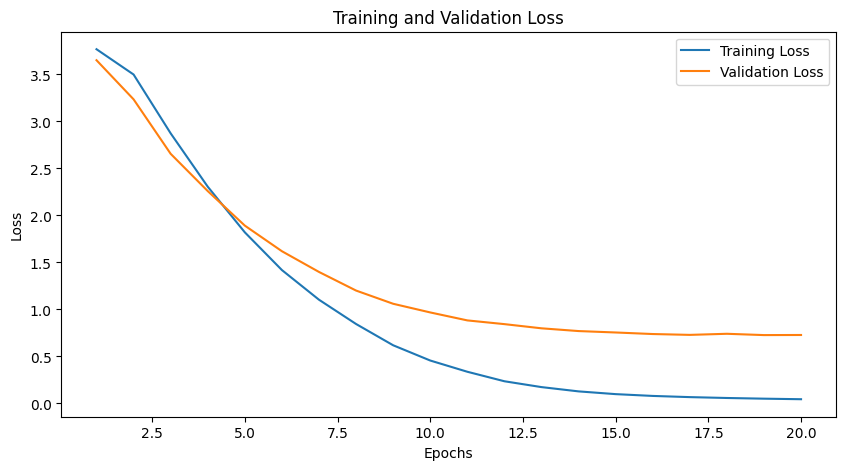

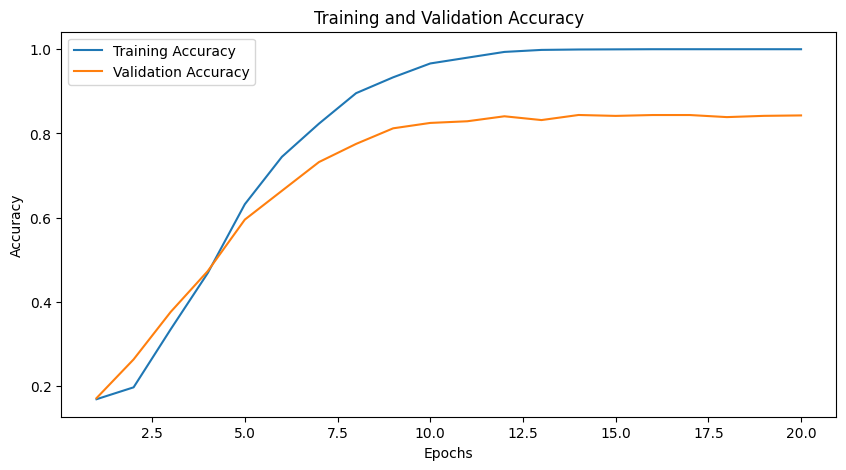

In [131]:
# Plot Training and Validation Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [132]:
# test the model
model.eval()  # it disables dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 84.84270734032413 %


In [134]:
# Define a function to evaluate the model on a given dataset
def evaluate_model(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate on the train set
train_accuracy = evaluate_model(train_dataloader, model, device)
print(f"Train Set Accuracy: {train_accuracy:.2f}%")

# Evaluate on the validation set
val_accuracy = evaluate_model(val_dataloader, model, device)
print(f"Validation Set Accuracy: {val_accuracy:.2f}%")

# Evaluate on the test set
test_accuracy = evaluate_model(test_dataloader, model, device)
print(f"Test Set Accuracy: {test_accuracy:.2f}%")

Train Set Accuracy: 100.00%
Validation Set Accuracy: 84.33%
Test Set Accuracy: 84.84%


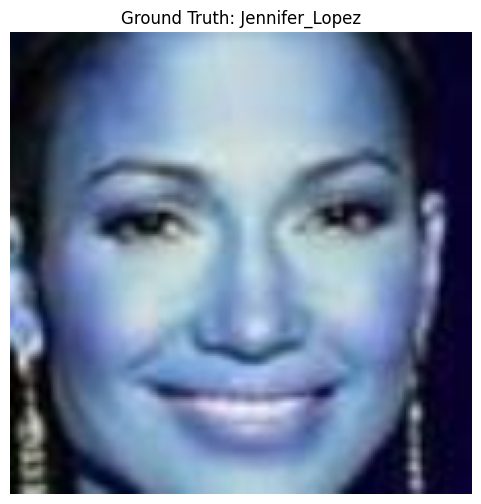

In [82]:
# Load the original image from dataset
image, label = test_dataset[343]  # Jennifer Lopez at index 343

# Convert to a NumPy format for visualization
transform = transforms.ToPILImage()
original_image = transform(image)

# Plot the original image
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Ground Truth: {name_list[label]}")
plt.axis("off")
plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


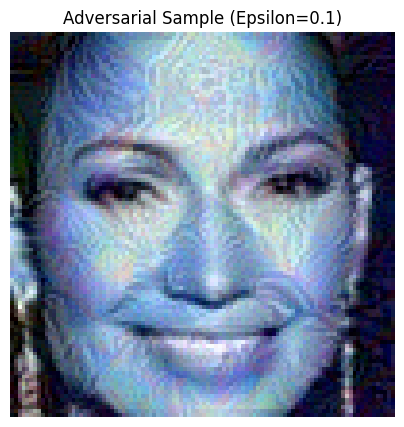

Adversarial image saved as 'adversarial_sample.jpg'
Model output shape: torch.Size([1, 1000])
Invalid predicted label: 643. It is out of range.


In [83]:

# Load the LFW dataset
dataset_path = "sample_data/LFW-dataset/"  # Change this to your dataset path
transform = transforms.ToTensor()
lfw_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Extract image 343
image_index = 343
image, label = lfw_dataset[image_index]
true_class = lfw_dataset.classes[label]

# Create a batch with one image
sub_dataset = Subset(lfw_dataset, [image_index])
sub_dataloader = DataLoader(sub_dataset, batch_size=1)

# Load a pretrained model (for example, ResNet18 or another CNN)
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model.eval()

# Step 1: PGD Attack (non-targeted)
def pgd_attack(model, image, epsilon, alpha, num_iterations):
    image = image.requires_grad_(True)  # Set requires_grad to True for the image

    # Loop for the defined number of iterations
    for i in range(num_iterations):
        # Zero all existing gradients
        model.zero_grad()

        # Forward pass the image through the model
        output = model(image)

        # Calculate loss (negative log-likelihood loss is commonly used for classification)
        loss = F.cross_entropy(output, torch.tensor([label]))  # Using true label for non-targeted attack
        loss.backward()  # Backpropagate to calculate gradients

        # Get the sign of the gradient
        grad_sign = image.grad.data.sign()

        # Update the image with the perturbation
        image = image + alpha * grad_sign

        # Project the image to be within the epsilon ball (clipping)
        image = torch.clamp(image, 0, 1)  # Make sure the pixel values are between 0 and 1
        image = torch.min(torch.max(image, original_image - epsilon), original_image + epsilon)

        # Reset gradients for the next iteration
        image = image.detach().requires_grad_(True)

    return image

# Step 2: Perform the attack
epsilon = 0.1  # Maximum perturbation (can be changed)
alpha = 0.01   # Step size
num_iterations = 40  # Number of iterations for PGD

# Save the original image to later compare
original_image = image.clone().detach()

# Perform the PGD attack
adversarial_image = pgd_attack(model, image.unsqueeze(0), epsilon, alpha, num_iterations)

# Step 3: Display the adversarial image
plt.figure(figsize=(5, 5))
plt.imshow(adversarial_image[0].detach().cpu().permute(1, 2, 0))  # Detach the tensor before visualizing
plt.title(f"Adversarial Sample (Epsilon={epsilon})")
plt.axis("off")
plt.show()

# Step 4: Save the adversarial image
TF.to_pil_image(adversarial_image[0].cpu()).save('adversarial_sample.jpg')
print("Adversarial image saved as 'adversarial_sample.jpg'")

# Step 5: Check the output shape
output = model(adversarial_image)
print("Model output shape:", output.shape)

# Get predicted class
_, predicted_label = output.max(1)

# Ensure the predicted label is valid
if predicted_label.item() < len(lfw_dataset.classes):
    predicted_class = lfw_dataset.classes[predicted_label.item()]
    print(f'Predicted class after attack: {predicted_class}')
else:
    print(f"Invalid predicted label: {predicted_label.item()}. It is out of range.")


In [86]:
!pip install cleverhans


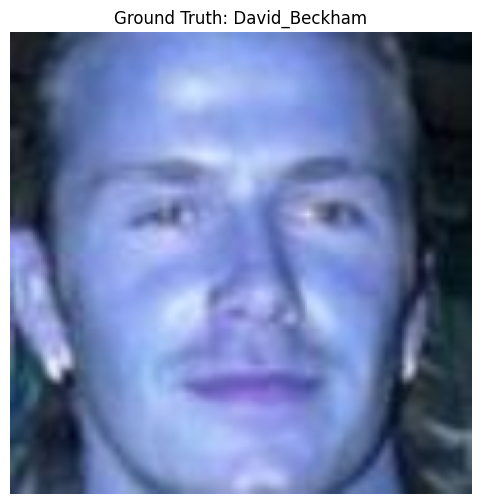

In [87]:
# Load the original image from dataset
image, label = test_dataset[442]  # David_Beckham at index 442

# Convert to a NumPy format for visualization
transform = transforms.ToPILImage()
original_image = transform(image)

# Plot the original image
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Ground Truth: {name_list[label]}")
plt.axis("off")
plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


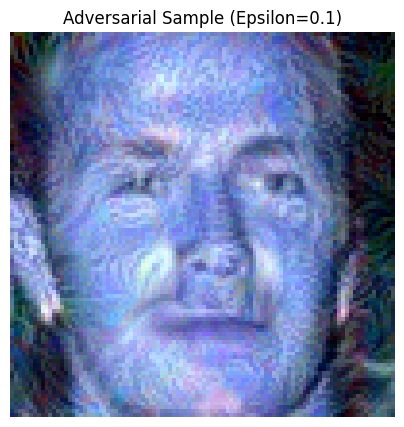

Adversarial image saved as 'adversarial_sample_David.jpg'
Model output shape: torch.Size([1, 1000])
Invalid predicted label: 365. It is out of range.


In [93]:


# Load the LFW dataset
dataset_path = "sample_data/LFW-dataset/"  # Change this to your dataset path
transform = transforms.ToTensor()
lfw_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Extract image 442
image_index = 442
image, label = lfw_dataset[image_index]
true_class = lfw_dataset.classes[label]

# Create a batch with one image
sub_dataset = Subset(lfw_dataset, [image_index])
sub_dataloader = DataLoader(sub_dataset, batch_size=1)

# Load a pretrained model (for example, ResNet18 or another CNN)
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model.eval()

# Step 1: PGD Attack (non-targeted)
def pgd_attack(model, image, epsilon, alpha, num_iterations):
    image = image.requires_grad_(True)  # Set requires_grad to True for the image

    # Loop for the defined number of iterations
    for i in range(num_iterations):
        # Zero all existing gradients
        model.zero_grad()

        # Forward pass the image through the model
        output = model(image)

        # Calculate loss (negative log-likelihood loss is commonly used for classification)
        loss = F.cross_entropy(output, torch.tensor([label]))  # Using true label for non-targeted attack
        loss.backward()  # Backpropagate to calculate gradients

        # Get the sign of the gradient
        grad_sign = image.grad.data.sign()

        # Update the image with the perturbation
        image = image + alpha * grad_sign

        # Project the image to be within the epsilon ball (clipping)
        image = torch.clamp(image, 0, 1)  # Make sure the pixel values are between 0 and 1
        image = torch.min(torch.max(image, original_image - epsilon), original_image + epsilon)

        # Reset gradients for the next iteration
        image = image.detach().requires_grad_(True)

    return image

# Step 2: Perform the attack
epsilon = 0.1  # Maximum perturbation (can be changed)
alpha = 0.01   # Step size
num_iterations = 40  # Number of iterations for PGD

# Save the original image to later compare
original_image = image.clone().detach()

# Perform the PGD attack
adversarial_image = pgd_attack(model, image.unsqueeze(0), epsilon, alpha, num_iterations)

# Step 3: Display the adversarial image
plt.figure(figsize=(5, 5))
plt.imshow(adversarial_image[0].detach().cpu().permute(1, 2, 0))  # Detach the tensor before visualizing
plt.title(f"Adversarial Sample (Epsilon={epsilon})")
plt.axis("off")
plt.show()

# Step 4: Save the adversarial image
TF.to_pil_image(adversarial_image[0].cpu()).save('adversarial_sample_David.jpg')
print("Adversarial image saved as 'adversarial_sample_David.jpg'")

# Step 5: Check the output shape
output = model(adversarial_image)
print("Model output shape:", output.shape)

# Get predicted class
_, predicted_label = output.max(1)

# Ensure the predicted label is valid
if predicted_label.item() < len(lfw_dataset.classes):
    predicted_class = lfw_dataset.classes[predicted_label.item()]
    print(f'Predicted class after attack: {predicted_class}')
else:
    print(f"Invalid predicted label: {predicted_label.item()}. It is out of range.")


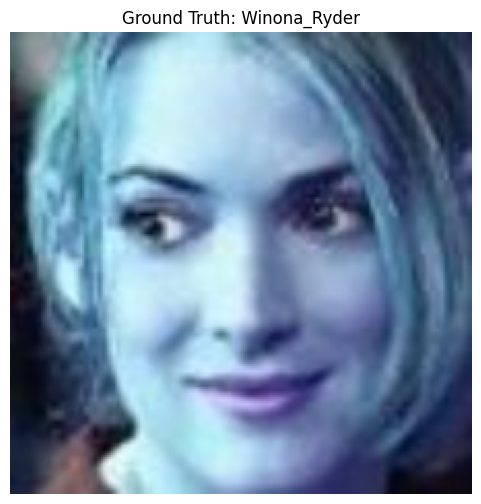

In [90]:
# Load the original image from dataset
image, label = test_dataset[53]  # David_Beckham at index 53

# Convert to a NumPy format for visualization
transform = transforms.ToPILImage()
original_image = transform(image)

# Plot the original image
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Ground Truth: {name_list[label]}")
plt.axis("off")
plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


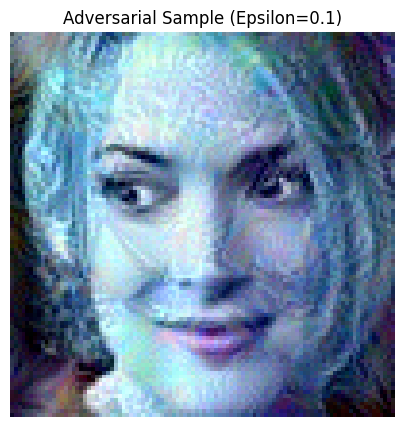

Adversarial image saved as 'adversarial_sample_Winona.jpg'
Model output shape: torch.Size([1, 1000])
Invalid predicted label: 903. It is out of range.


In [97]:


# Load the LFW dataset
dataset_path = "sample_data/LFW-dataset/"  # Change this to your dataset path
transform = transforms.ToTensor()
lfw_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Extract image 53
image_index = 53
image, label = lfw_dataset[image_index]
true_class = lfw_dataset.classes[label]

# Create a batch with one image
sub_dataset = Subset(lfw_dataset, [image_index])
sub_dataloader = DataLoader(sub_dataset, batch_size=1)

# Load a pretrained model (for example, ResNet18 or another CNN)
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model.eval()

# Step 1: PGD Attack (non-targeted)
def pgd_attack(model, image, epsilon, alpha, num_iterations):
    image = image.requires_grad_(True)  # Set requires_grad to True for the image

    # Loop for the defined number of iterations
    for i in range(num_iterations):
        # Zero all existing gradients
        model.zero_grad()

        # Forward pass the image through the model
        output = model(image)

        # Calculate loss (negative log-likelihood loss is commonly used for classification)
        loss = F.cross_entropy(output, torch.tensor([label]))  # Using true label for non-targeted attack
        loss.backward()  # Backpropagate to calculate gradients

        # Get the sign of the gradient
        grad_sign = image.grad.data.sign()

        # Update the image with the perturbation
        image = image + alpha * grad_sign

        # Project the image to be within the epsilon ball (clipping)
        image = torch.clamp(image, 0, 1)  # Make sure the pixel values are between 0 and 1
        image = torch.min(torch.max(image, original_image - epsilon), original_image + epsilon)

        # Reset gradients for the next iteration
        image = image.detach().requires_grad_(True)

    return image

# Step 2: Perform the attack
epsilon = 0.1  # Maximum perturbation (can be changed)
alpha = 0.01   # Step size
num_iterations = 40  # Number of iterations for PGD

# Save the original image to later compare
original_image = image.clone().detach()

# Perform the PGD attack
adversarial_image = pgd_attack(model, image.unsqueeze(0), epsilon, alpha, num_iterations)

# Step 3: Display the adversarial image
plt.figure(figsize=(5, 5))
plt.imshow(adversarial_image[0].detach().cpu().permute(1, 2, 0))  # Detach the tensor before visualizing
plt.title(f"Adversarial Sample (Epsilon={epsilon})")
plt.axis("off")
plt.show()

# Step 4: Save the adversarial image
TF.to_pil_image(adversarial_image[0].cpu()).save('adversarial_sample_Winona.jpg')
print("Adversarial image saved as 'adversarial_sample_Winona.jpg'")

# Step 5: Check the output shape
output = model(adversarial_image)
print("Model output shape:", output.shape)

# Get predicted class
_, predicted_label = output.max(1)

# Ensure the predicted label is valid
if predicted_label.item() < len(lfw_dataset.classes):
    predicted_class = lfw_dataset.classes[predicted_label.item()]
    print(f'Predicted class after attack: {predicted_class}')
else:
    print(f"Invalid predicted label: {predicted_label.item()}. It is out of range.")
